# Zoning and the cost of living

In [1]:
%load_ext google.cloud.bigquery

In [2]:
import altair as alt
import pandas as pd

## Housing costs

How expensive is housing in the Charlottesville area? Over one in four households in the Charlottesville Metropolitan Statistical Area were cost-burdened in 2018, meaning that they spent more than 30% of their income on housing. Over one in eight households were severly cost-burdened, meaning they spent more than 50% of their income on housing.

Even some high-income households are cost-burdened, including over 2,000 households above the area median income (AMI). However, the proportion of cost-burdened households is highest for lower-income households. Among households earning 30% of the AMI, about 72% were cost-burdened, and about 60% were severely cost-burdened.

In [3]:
chas_datadict = pd.read_excel("/Users/josh.carp/Downloads/050/CHAS data dictionary 14-18.xlsx", sheet_name="Table 8")
chas_data = df = pd.read_csv('/Users/josh.carp/Downloads/050/Table8.csv', encoding='latin-1')
chas_data = chas_data[chas_data["name"].str.endswith(", Virginia")]
chas_data["name"] = chas_data["name"].str.replace(" city", " City").str.replace(", Virginia", "")

/var/folders/k8/zmjmsrr92n18ywxl6hdq1svw0000gn/T/ipykernel_7638/1646634688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chas_data["name"] = chas_data["name"].str.replace(" city", " City").str.replace(", Virginia", "")


In [4]:
incomes = {
    "0-30%": "less than or equal to 30% of HAMFI",
    "30-50%": "greater than 30% but less than or equal to 50% of HAMFI",
    "50-80%": "greater than 50% but less than or equal to 80% of HAMFI",
    "80-100%": "greater than 80% but less than or equal to 100% of HAMFI",
    ">100%": "greater than 100% of HAMFI",
}
cost_burdens = {
    "30%": ("greater than 30% but less than or equal to 50%", "greater than 50%"),
    "50%": ("greater than 50%",),
    
}
cville_msa_counties = {
    "Albemarle County",
    "Charlottesville City",
    "Fluvanna County",
    "Greene County",
    "Nelson County",
}

base_conditions = (chas_datadict['Tenure'].isin(['Renter occupied', 'Owner occupied'])) & (chas_datadict['Facilities'] == 'All')
frames = []
for income_label, income_value in incomes.items():
    for burden_label, burden_values in cost_burdens.items():
        burden_columns = chas_datadict['Column Name'][base_conditions & (chas_datadict['Household income'] == income_value) & (chas_datadict['Cost burden'].isin(burden_values))]
        all_columns = chas_datadict['Column Name'][base_conditions & (chas_datadict['Household income'] == income_value) & (chas_datadict['Cost burden'].isin(("All",)))]
        burden_count = chas_data[burden_columns].sum(axis=1)
        total_count = chas_data[all_columns].sum(axis=1)
        frame = pd.DataFrame({"name": chas_data["name"], "income_level": income_label, "burden_level": burden_label, "burden_count": burden_count, "total_count": total_count})
        frames.append(frame)
summary_long = pd.concat(frames)

In [5]:
summary_agg_burden = summary_long[summary_long["name"].isin(cville_msa_counties)].groupby(["burden_level"]).sum().reset_index()
summary_agg_burden["burden_prop"] = summary_agg_burden["burden_count"] / summary_agg_burden["total_count"]
summary_agg_burden

,burden_level,burden_count,total_count,burden_prop
0,30%,21918,82885,0.264439
1,50%,10748,82885,0.129674


In [6]:
summary_agg_burden_income = summary_long[summary_long["name"].isin(cville_msa_counties)].groupby(["burden_level", "income_level"]).sum().reset_index()
summary_agg_burden_income["burden_prop"] = summary_agg_burden_income["burden_count"] / summary_agg_burden_income["total_count"]

In [7]:
alt.Chart(summary_agg_burden_income).mark_bar().encode(
    y=alt.X("income_level:N", sort="y"),
    x=alt.Y("burden_count:Q"),
    color="income_level:N",
    tooltip="burden_count:Q",
    column="burden_level",
).properties(
    title="Count of cost-burdened households in the Charlottesville MSA",
)

alt.Chart(...)

In [8]:
alt.Chart(summary_agg_burden_income).mark_bar().encode(
    y=alt.X("income_level:N", sort="y"),
    x=alt.Y("burden_prop:Q"),
    color="income_level:N",
    tooltip="burden_prop:Q",
    column="burden_level",
).properties(
    title="Proportion of cost-burdened households in the Charlottesville MSA",
)

alt.Chart(...)

Further, **housing costs have been rising faster than inflation over the past decade**.

- Median assessments for detached single-family homes, attached single-family homes, and condos have risen from about \\$200,000 in 2021-adjusted dollars in 2012 to about \\$310,000 in 2021.
- Median sale prices have risen from \\$184,000 to \\$361,000.

In [9]:
%%bigquery assessments
select distinct
    assessments.TaxYear,
    percentile_cont(assessments.TotalValue, 0.5) over (partition by assessments.TaxYear) as TotalValue,
    percentile_cont(assessments.TotalValue, 0.5) over (partition by assessments.TaxYear)
        * cpi.value
        / (
            select
                value
            from `bigquery-public-data.bls.cpi_u`
            where
                series_id = "CUUR0000SA0"
                and period = "M13"
                and year = 2021
        )
        as TotalValueAdjusted,
from `cvilledata.cville_open_data.real_estate_all_assessments` assessments
join `cvilledata.cville_open_data.real_estate_residential_details` residential using (ParcelNumb)
join `bigquery-public-data.bls.cpi_u` cpi on assessments.TaxYear = cpi.year
where
    assessments.TaxYear >= 2012
    and residential.UseCode in ("Single Family", "Single Family Attached", "Condominium")
    and residential.YearBuilt < 2012
    and cpi.series_id = "CUUR0000SA0"
    and cpi.period = "M13"
order by TaxYear desc

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.88rows/s]


In [10]:
alt.Chart(assessments).mark_bar().encode(
    x=alt.X("TaxYear:N", sort="x"),
    y=alt.Y("TotalValueAdjusted:Q"),
    tooltip="TotalValueAdjusted",
).properties(
    title="Median home assessment by year, in 2021 dollars",
)

alt.Chart(...)

In [11]:
%%bigquery sales
select distinct
    extract(year from sales.SaleDate) as SaleYear,
    percentile_cont(sales.SaleAmount, 0.5) over (partition by extract(year from sales.SaleDate)) as SaleAmount,
    percentile_cont(sales.SaleAmount, 0.5) over (partition by extract(year from sales.SaleDate))
        * cpi.value
        / (
            select
                value
            from `bigquery-public-data.bls.cpi_u`
            where
                series_id = "CUUR0000SA0"
                and period = "M13"
                and year = 2021
        )
        as SaleAmountAdjusted,
from `cvilledata.cville_open_data.real_estate_sales` sales
join `cvilledata.cville_open_data.real_estate_residential_details` residential using (ParcelNumb)
join `bigquery-public-data.bls.cpi_u` cpi on extract(year from sales.SaleDate) = cpi.year
where
    sales.SaleAmount != 0
    and extract(year from sales.SaleDate) >= 2012
    and residential.UseCode in ("Single Family", "Single Family Attached", "Condominium")
    and residential.YearBuilt < 2012
    and cpi.series_id = "CUUR0000SA0"
    and cpi.period = "M13"
order by SaleYear desc

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.24rows/s]


In [12]:
alt.Chart(sales).mark_bar().encode(
    x=alt.X("SaleYear:N", sort="x"),
    y=alt.Y("SaleAmountAdjusted:Q"),
    tooltip="SaleAmountAdjusted",
).properties(
    title="Median home sale price by year, in 2021 dollars",
)

alt.Chart(...)

**How can zoning change housing prices?**

Our current zoning code limits much of the city to single-family detached housing, but single-family detached homes are the most expensive housing form:

- In 2021, the median single-family detached home was assessed at about \\$129,000 more than the median single-family attached home and about \\$139,000 more than the typical condo.
- Similarly, the median single-family home that sold in 2021 sold for about \\$130,000 more than the median single-family attached home and \\$168,000 more than the typical condo.

**We can lower housing prices by allowing smaller multi-family homes that use land more efficiently.**

In [13]:
%%bigquery assessments_by_use
select distinct
    residential.UseCode,
    percentile_cont(assessments.TotalValue, 0.5) over (partition by residential.UseCode) as TotalValue,
from `cvilledata.cville_open_data.real_estate_all_assessments` assessments
join `cvilledata.cville_open_data.real_estate_residential_details` residential using (ParcelNumb)
where
    assessments.TaxYear = 2021
    and residential.UseCode in ("Single Family", "Single Family Attached", "Condominium")
order by TotalValue desc

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05rows/s]


In [14]:
alt.Chart(assessments_by_use).mark_bar().encode(
    y=alt.X("UseCode:N", sort="-x"),
    x=alt.Y("TotalValue:Q"),
    color=alt.X("UseCode:N", sort=alt.SortField("TotalValueAdjusted", "descending")),
    tooltip="TotalValue:Q",
).properties(
    title="Median home assessment by use code by year, 2021",
)

alt.Chart(...)

In [15]:
%%bigquery sales_by_use
select distinct
    residential.UseCode,
    percentile_cont(sales.SaleAmount, 0.5) over (partition by residential.UseCode) as SaleAmount,
from `cvilledata.cville_open_data.real_estate_sales` sales
join `cvilledata.cville_open_data.real_estate_residential_details` residential using (ParcelNumb)
where
    SaleAmount != 0
    and extract(year from SaleDate) = 2021
    and residential.UseCode in ("Single Family", "Single Family Attached", "Condominium")
order by SaleAmount desc

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38rows/s]


In [16]:
alt.Chart(sales_by_use).mark_bar().encode(
    y=alt.X("UseCode:N", sort="-x"),
    x=alt.Y("SaleAmount:Q"),
    color=alt.X("UseCode:N", sort=alt.SortField("SaleAmountAdjusted", "descending")),
    tooltip="SaleAmount:Q",
).properties(
    title="Median home sale price by use code by year, 2021",
)

alt.Chart(...)

## Transportation costs

Getting around by car is expensive. The [Center for Neighborhood Technology](https://cnt.org/) estimates that a household in the Charlottesville region at the area median income (AMI) spends about \\$14,000 on transportation per year.

In [17]:
%%bigquery transit_cost_msa
select
    name,
    t_cost_ami,
    t_cost_80ami,
from cvilledata.cnt.cbsa
where name = "Charlottesville, VA"

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/rows]


In [18]:
transit_cost_msa

,name,t_cost_ami,t_cost_80ami
0,"Charlottesville, VA",13897,12125


**How can zoning affect transportation costs?**

While some transportation costs, such as car payments, are fixed, gas and maintenance costs increase as households drive more. On average, Charlottesville residents have shorter commutes than residents of Albemarle, Fluvanna, Greene, and Nelson Counties. Charlottesville residents are also less likely to own a car. As a result, Charlottesville households save about \\$4,000 per year in transportation costs relative to Nelson County.

**We can lower transportation costs by allowing more housing in the urban ring, close to jobs and amenities**.

In [19]:
%%bigquery transit_cost_by_county
select
    name,
    t_cost_ami,
    t_cost_80ami,
from cvilledata.cnt.virginia_county
where name in ("Charlottesville", "Albemarle", "Fluvanna", "Greene", "Nelson")

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60rows/s]


In [20]:
alt.Chart(transit_cost_by_county).mark_bar().encode(
    y=alt.X("name:N", sort="-x"),
    x=alt.Y("t_cost_ami:Q"),
    color="name:N",
    tooltip="t_cost_ami:Q",
).properties(
    title="Estimated transportation cost by county at area median income",
)

alt.Chart(...)

## Energy costs

Residental energy costs make up a significant fraction of the cost of living, with the average household spending [$1,856/year in 2015](https://www.eia.gov/consumption/residential/data/2015/c&e/pdf/ce1.1.pdf).

**How can zoning affect home energy costs?**

Multi-family homes reduce heat loss via shared walls. Multi-family homes also tend to be smaller than single-family homes, further reducing heating and cooling costs. Overall, the typical household in multi-family housing of five or more units spends about half as much on home energy as the typical single-family home, for a savings of about \\$1,150 per year.

**We can lower home energy costs by allowing more multi-family homes.**

In [21]:
%%bigquery hh_energy_use_by_type
select
    *
from `cvilledata.eia.recs_2015_ce1_unit_type`

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57rows/s]


In [22]:
alt.Chart(hh_energy_use_by_type).mark_bar().encode(
    y=alt.X("housing_unit_type:N", sort="-x"),
    x=alt.Y("per_household_dollars:Q"),
    color="housing_unit_type:N",
    tooltip="per_household_dollars:Q",
).properties(
    title="Average household energy costs by housing type, 2015",
)

alt.Chart(...)

## Parking

The current Charlottesville zoning ordinance [requires parking for all residential uses](https://library.municode.com/va/charlottesville/codes/code_of_ordinances?nodeId=CO_CH34ZO_ARTIXGEAPRE_DIV2OREPA_S34-984OREPAREPEUS). However, parking spaces add to the cost of housing. Parking spaces take up space; each space in a surface parking lot occupies about 330 square feet, larger than a typical bedroom [1]. 

Decades of research show that parking requirements both increase rents and sale prices and discourage the development of smaller, lower-cost homes [2]. These costs are particularly burdensome for affordable housing developments, where parking costs make up a larger fraction of total costs, and since car ownership is expensive, low-income households are less likely to own cars.

**We can lower housing costs by rolling back parking mandates and unbundling parking costs from rents.**

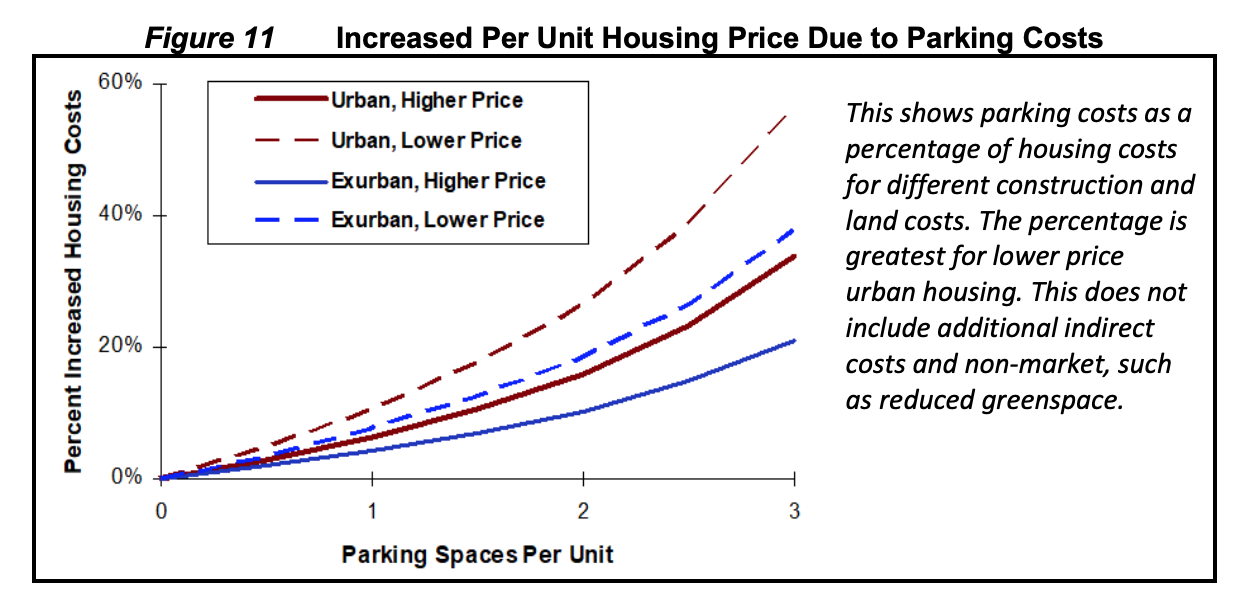

1. https://www.vtpi.org/park-hou.pdf
2. https://www.jtlu.org/index.php/jtlu/article/view/1340/1188

## Conclusions

- The cost of living is unacceptably high for many households in the Charlottesville area.
- Zoning can lower housing costs by allowing lower-cost housing forms, such as multiplexes, townhomes, and apartment.
- Zoning can lower transportation costs by allowing more housing close to jobs and amenities, in particular in the urban ring.
- Zoning can lower home energy costs by allowing housing forms that use less energy, such as multiplexes, townhomes, and apartments.
- Zoning can lower housing costs by rolling back unscientific parking mandates, which will reduce rents and encourage the production of lower-cost multi-family homes.